# Final Project: Predicting Cefepime Resistance in Escherichia coli

This project aims to build models to predict Cefepime susceptibility (Sensitive vs Resistant) in Escherichia coli using genomic data. We'll explore different models and feature sets to achieve the best performance.

This analysis evaluates five machine learning approaches for predicting antibiotic resistance from genomic data. Each method brings distinct advantages in terms of feature interpretation, model complexity, and optimization strategies. The comparison focuses on:

- Logistic Regression 
- Random Forest 
- Decision Tree 
- CNN 
- RNN

All models were evaluated using cross-validation techniques appropriate to their demands, with careful attention to hyperparameter tuning where applicable.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from scipy import stats

from sklearn import model_selection, linear_model, ensemble, metrics
from sklearn import tree, model_selection, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (cross_val_score, GridSearchCV, 
                                   StratifiedKFold)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (balanced_accuracy_score, confusion_matrix, 
                            classification_report, roc_auc_score, roc_curve)
from sklearn.exceptions import UndefinedMetricWarning

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv1D, MaxPooling1D, 
                                   Flatten, SimpleRNN, LSTM)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt
import seaborn as sns

import time
import warnings

# 1. Load and Prep Data
Load the data 

In [2]:
seed = 130

def load_data():
    """
    Load the data 
    """
    # Presence absence features
    train_pa_genes = pd.read_csv('/Users/vivianwang/Desktop/workshops/data/train_test_data/train_pa_genes.csv').set_index('genome_id')
    test_pa_genes = pd.read_csv('/Users/vivianwang/Desktop/workshops/data/train_test_data/test_pa_genes.csv').set_index('genome_id')
    
    # Load Kmer data
    train_kmers = np.load('/Users/vivianwang/Desktop/workshops/data/train_test_data/train_kmers.npy', allow_pickle=True)
    test_kmers = np.load('/Users/vivianwang/Desktop/workshops/data/train_test_data/test_kmers.npy', allow_pickle=True)

    # Load target data & IDs
    y_train = np.load('/Users/vivianwang/Desktop/workshops/data/train_test_data/y_train.npy', allow_pickle=True)
    y_train_ids = np.load('/Users/vivianwang/Desktop/workshops/data/train_test_data/train_ids.npy', allow_pickle=True).astype(str)
    y_test_ids = np.load('/Users/vivianwang/Desktop/workshops/data/train_test_data/test_ids.npy', allow_pickle=True).astype(str)

    # Load raw gene data for optional neural network section
    train_gene_alignment = pd.read_csv('/Users/vivianwang/Desktop/workshops/data/train_test_data/train_genes.csv')
    
    return train_pa_genes, test_pa_genes, train_kmers, test_kmers, y_train, y_train_ids, y_test_ids, train_gene_alignment
# Load everything
train_pa_genes, test_pa_genes, X_train_kmers, X_test_kmers, y_train, y_train_ids, y_test_ids, train_gene_alignment = load_data()

Prep the data

In [3]:
np.unique(y_train)

array(['R', 'S'], dtype=object)

In [4]:
train_pa_genes.head(3)

,gb|U00096.3|-|3324062-3324911|ARO:3003386|Ecol_folP_SLF,gb|AP009048.1|+|3760295-3762710|ARO:3003303|Ecol_gyrB_AMU,gb|BA000007.3|+|4990267-4994296|ARO:3003288|Ecol_rpoB_RIF,gb|AH002539.2|+|1760-2945|ARO:3003368|Ecol_EFTu_KIR,gb|AE014075.1|-|3901532-3902762|ARO:3003369|Ecol_EFTu_PLV,gb|U00096.3|-|2336792-2339420|ARO:3003294|Ecol_gyrA_FLO,gb|AE006468.2|-|4038867-4041282|ARO:3003307|Sser_gyrB_FLO,gb|HG738867.1|+|2934266-2935658|ARO:3003890|Ecol_UhpT_FOF,gb|HG738867.1|-|2233288-2234647|ARO:3003889|Ecol_GlpT_FOF,gb|HG738867.1|+|2930707-2931298|ARO:3003893|Ecol_uhpA_FOF,...,gb|X01702.1|+|484-1285|ARO:3002659|APH(6)-Ic,gb|JX259319.1|+|0-681|ARO:3002771|QnrB58,gb|EU675686.2|+|3196-4042|ARO:3002616|aadA16,gb|HQ418999.2|+|0-681|ARO:3002746|QnrB31,gb|JX423831.1|+|2676-3474|ARO:3001778|OXA-232,gb|AY536519.1|+|37-937|ARO:3002372|VEB-3,gb|KJ158441.1|+|2732-3377|ARO:3002789|QnrD2,gb|KF526113.1|+|0-1146|ARO:3002112|CMY-100,gb|X03988.1|+|382-1642|ARO:3000363|EreB,gb|AJ310778.1|+|7003-7573|ARO:3003015|dfrA19
genome_id,,,,,,,,,,,,,,,,,,,,,
562.22444,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562.42705,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562.42733,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X_train_pa = np.array(train_pa_genes)
X_test_pa = np.array(test_pa_genes)

In [6]:
# Convert y_train to binary (0 for 'S', 1 for 'R')
y_train_binary = np.where(y_train == 'R', 1, 0).ravel()

# 2. Logistic Regression on PA features with Feature Selection
Logistic Regression predicts resistance (1) or sensitivity (0) using gene presence/absence data. Hyperparameter Tuning with Grid Search is used. 

Best Logistic Regression parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV balanced accuracy: 0.876


/var/folders/85/tvr6wqy96b7gv_s60pqp7h840000gn/T/ipykernel_82615/1927713124.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


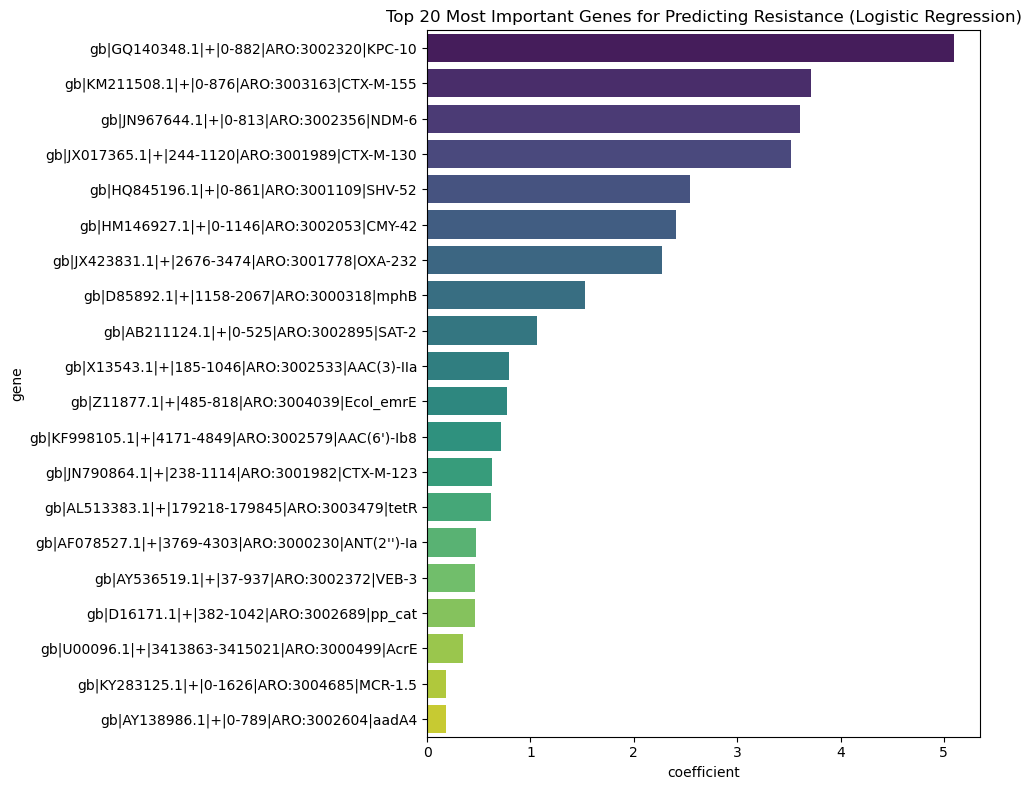

In [7]:
# Initialize stratified 5-fold cross-validation
cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Parameter grid for logistic regression
param_grid_log = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Grid search with cross-validation
log_grid = model_selection.GridSearchCV(
    linear_model.LogisticRegression(class_weight='balanced', max_iter=10000, random_state=seed),
    param_grid_log,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)

log_grid.fit(X_train_pa, y_train_binary)

# Best parameters and performance
print("Best Logistic Regression parameters:", log_grid.best_params_)
print(f"Best CV balanced accuracy: {log_grid.best_score_:.3f}")

# Train final model with best parameters
best_log = log_grid.best_estimator_
best_log.fit(X_train_pa, y_train_binary)

# Get feature importances
feature_importances = pd.DataFrame({
    'gene': train_pa_genes.columns,
    'coefficient': best_log.coef_[0]
}).sort_values('coefficient', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(10, 8))
sns.barplot(
    x='coefficient', 
    y='gene', 
    data=feature_importances.head(20),
    palette='viridis'
)
plt.title("Top 20 Most Important Genes for Predicting Resistance (Logistic Regression)")
plt.tight_layout()
plt.show()


# 3.Random Forest with Bayesian Optimization
Random Forest uses an ensemble of decision trees with Bayesian optimization for hyperparameter tuning.

In [8]:


# Define the function to optimize
def rf_cv(n_estimators, max_depth, min_samples_split):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    
    rf = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        class_weight='balanced_subsample',
        random_state=seed,
        n_jobs=-1
    )
    
    cv_scores = model_selection.cross_val_score(
        rf, X_train_pa, y_train_binary,
        cv=cv, scoring='balanced_accuracy', n_jobs=-1
    )
    return np.mean(cv_scores)

# Set parameter bounds
pbounds = {
    'n_estimators': (50, 200),
    'max_depth': (5, 30),
    'min_samples_split': (2, 10)
}

# Initialize optimizer
optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=pbounds,
    random_state=seed
)

# Run optimization
optimizer.maximize(
    init_points=5,
    n_iter=15
)

# Get best parameters
best_rf_params = optimizer.max['params']
best_rf_params = {k: int(v) if k in ['n_estimators', 'max_depth', 'min_samples_split'] else v 
                 for k, v in best_rf_params.items()}
print("Best Random Forest parameters:", best_rf_params)


|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.8141    | 8.541     | 4.492     | 133.2     |
| 2         | 0.8182    | 8.145     | 5.951     | 188.2     |
| 3         | 0.8032    | 14.5      | 3.012     | 199.8     |
| 4         | 0.8299    | 24.27     | 7.841     | 54.74     |
| 5         | 0.7899    | 25.26     | 2.412     | 135.7     |
| 6         | 0.8157    | 10.95     | 5.653     | 189.3     |
| 7         | 0.834     | 12.41     | 8.278     | 50.13     |
| 8         | 0.8348    | 6.671     | 9.531     | 67.72     |
| 9         | 0.829     | 5.082     | 4.587     | 92.8      |
| 10        | 0.7991    | 29.54     | 3.277     | 81.92     |
| 11        | 0.8365    | 5.078     | 2.858     | 59.69     |
| 12        | 0.8307    | 5.711     | 9.459     | 163.3     |
| 13        | 0.824     | 5.015     | 2.291     | 76.7      |
| 14        | 0.8315    | 5.318     | 8.958     | 108.8     |
| 15    

Final Random Forest Model

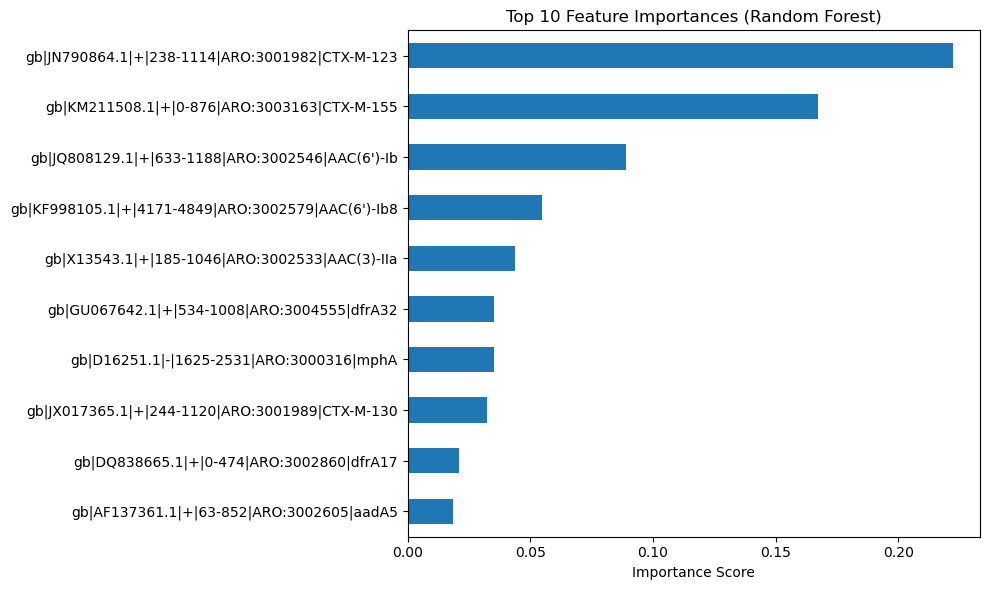

In [9]:
# Train final model with best parameters
rf_final = ensemble.RandomForestClassifier(
    **best_rf_params,
    class_weight='balanced_subsample',
    random_state=seed,
    n_jobs=-1
)

rf_final.fit(X_train_pa, y_train_binary)

# Feature importance
importances = rf_final.feature_importances_
top_features = pd.Series(importances, index=train_pa_genes.columns).sort_values(ascending=False)[:10]

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features.sort_values().plot.barh()
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# 4. Decision Tree with Nested Cross-Validation
Decision Tree applies nested cross-validation to select the best tree structure.

In [10]:
# Parameter grid for decision tree
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Outer CV loop
outer_cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
outer_scores = []

for i, (train_idx, val_idx) in enumerate(outer_cv.split(X_train_pa, y_train_binary)):
    X_train_outer, X_val_outer = X_train_pa[train_idx], X_train_pa[val_idx]
    y_train_outer, y_val_outer = y_train_binary[train_idx], y_train_binary[val_idx]
    
    # Inner CV grid search
    inner_cv = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    dt_grid = model_selection.GridSearchCV(
        tree.DecisionTreeClassifier(class_weight='balanced', random_state=seed),
        param_grid_dt,
        cv=inner_cv,
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    dt_grid.fit(X_train_outer, y_train_outer)
    
    # Evaluate on validation fold
    y_pred = dt_grid.predict(X_val_outer)
    fold_score = metrics.balanced_accuracy_score(y_val_outer, y_pred)
    outer_scores.append(fold_score)
    print(f"Fold {i+1} Balanced Accuracy: {fold_score:.3f}")

print(f"\nNested CV Balanced Accuracy: {np.mean(outer_scores):.3f} (±{np.std(outer_scores):.3f})")

Fold 1 Balanced Accuracy: 0.808
Fold 2 Balanced Accuracy: 0.846
Fold 3 Balanced Accuracy: 0.854
Fold 4 Balanced Accuracy: 0.825
Fold 5 Balanced Accuracy: 0.854

Nested CV Balanced Accuracy: 0.837 (±0.018)


Visualizing the Decision Tree

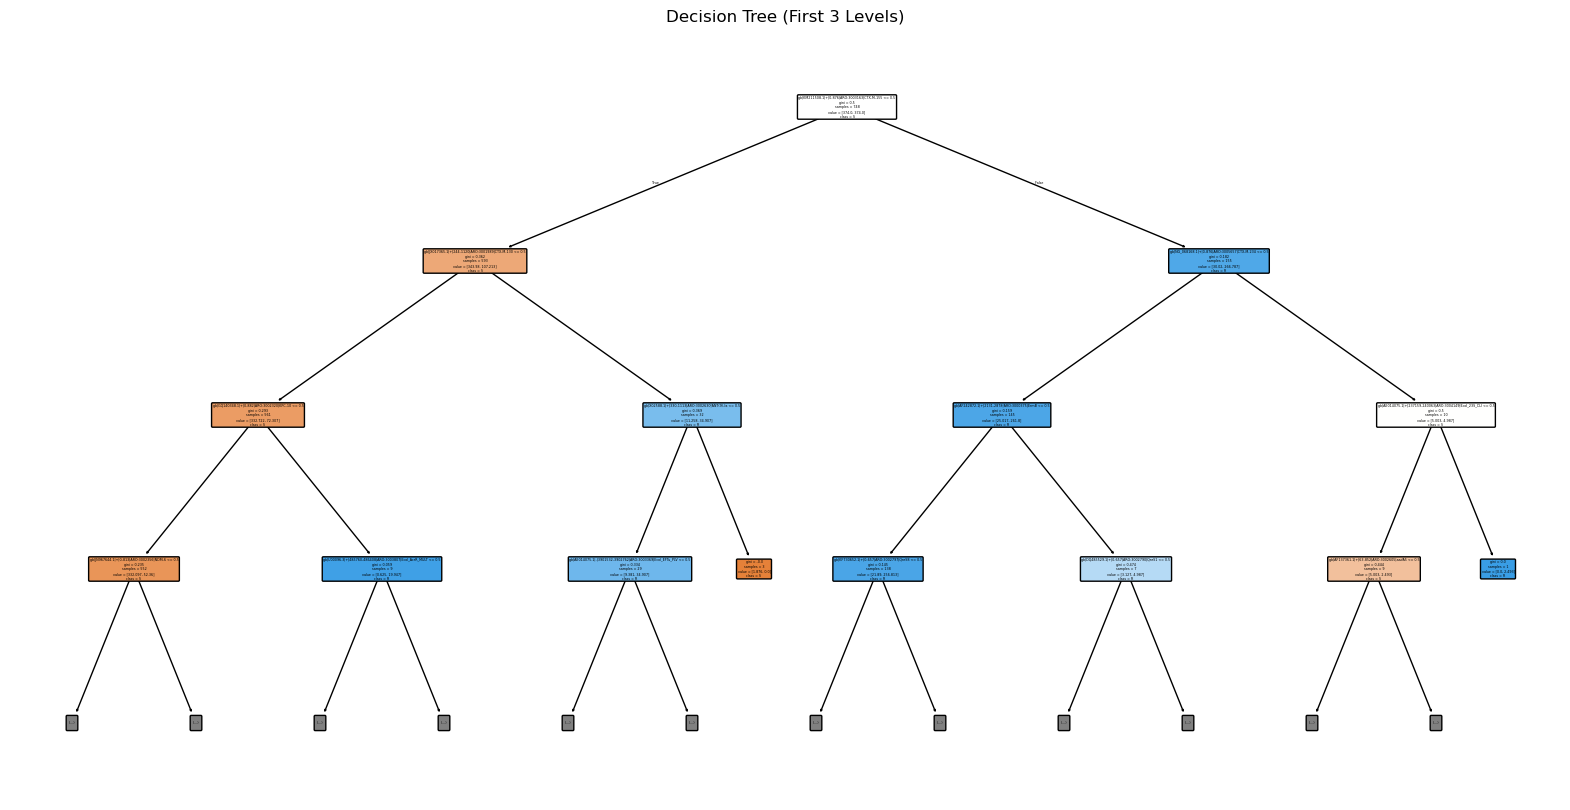

In [11]:
# Train final model with best parameters from full data grid search
dt_grid_full = model_selection.GridSearchCV(
    tree.DecisionTreeClassifier(class_weight='balanced', random_state=seed),
    param_grid_dt,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)
dt_grid_full.fit(X_train_pa, y_train_binary)
best_dt = dt_grid_full.best_estimator_

# Visualize the tree
plt.figure(figsize=(20,10))
tree.plot_tree(
    best_dt,
    max_depth=3,
    feature_names=train_pa_genes.columns,
    class_names=['S','R'],
    filled=True,
    rounded=True
)
plt.title("Decision Tree (First 3 Levels)")
plt.show()

# 5. CNN
CNN (Convolutional Neural Network) processes gene presence/absence data as sequences.

In [12]:

# Set random seed for reproducibility
np.random.seed(130)

# Load data (assuming load_data() function is defined)
train_pa_genes, test_pa_genes, X_train_kmers, X_test_kmers, y_train, y_train_ids, y_test_ids, train_gene_alignment = load_data()

# Convert target to binary (0=Sensitive, 1=Resistant)
y_train_binary = np.where(y_train == 'S', 0, 1)

# Prepare feature sets
X_train_pa = np.array(train_pa_genes)
X_test_pa = np.array(test_pa_genes)

# Create stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=130)

print("\nTraining CNN with Gene Presence/Absence Features...")
start_time = time.time()

def create_cnn(**kwargs):
    optimizer = kwargs.get('optimizer', 'adam')
    dropout_rate = kwargs.get('dropout_rate', 0.3)
    filters = kwargs.get('filters', 64)
    
    model = Sequential([
        Conv1D(filters, 5, activation='relu', input_shape=(X_train_pa.shape[1], 1)),
        MaxPooling1D(2),
        Dropout(dropout_rate),
        Conv1D(filters*2, 3, activation='relu'),
        MaxPooling1D(2),
        Dropout(dropout_rate),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(dropout_rate + 0.1),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# Wrap in scikit-learn compatible classifier
cnn_model = KerasClassifier(
    model=create_cnn,
    epochs=15,
    batch_size=32,
    verbose=0,
    optimizer='adam',
    dropout_rate=0.3,
    filters=64,
    random_state=130
)

# Parameter grid for tuning
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3, 0.4],
    'filters': [32, 64]
}

# Grid search for best parameters
grid_search_cnn = GridSearchCV(
    estimator=cnn_model,
    param_grid=param_grid,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=1
)

# Reshape for CNN
X_cnn = X_train_pa.reshape(X_train_pa.shape[0], X_train_pa.shape[1], 1)

grid_search_cnn.fit(X_cnn, y_train_binary)

# Best model
best_cnn = grid_search_cnn.best_estimator_

# Cross-validated performance
cnn_scores = cross_val_score(
    best_cnn,
    X_cnn,
    y_train_binary,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=1
)
print(f"Best CNN Parameters: {grid_search_cnn.best_params_}")
print(f"CNN CV Balanced Accuracy: {np.mean(cnn_scores):.3f} (±{np.std(cnn_scores):.3f})")
print(f"Training time: {time.time() - start_time:.1f} seconds")


Training CNN with Gene Presence/Absence Features...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-30 17:42:52.707152: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2025-04-30 17:42:57.889126: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-30 17:42:57.889402: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Best CNN Parameters: {'dropout_rate': 0.2, 'filters': 64, 'optimizer': 'adam'}
CNN CV Balanced Accuracy: 0.858 (±0.013)
Training time: 59.1 seconds


In [13]:
best_cnn.model_.summary()


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_72 (Conv1D)              │ (None, 155, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_72 (MaxPooling1D) │ (None, 77, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 77, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_73 (Conv1D)              │ (None, 75, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_73 (MaxPooling1D) │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 4736)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 64)             │       303,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 984,965 (3.76 MB)

 Trainable params: 328,321 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 656,644 (2.50 MB)

# 6. RNN
RNN (Recurrent Neural Network) uses sequential modeling but performs poorly compared to other models.

In [14]:


# Set all random seeds for reproducibility
seed = 130
np.random.seed(seed)
tf.random.set_seed(seed)

def build_better_rnn(rnn_units=64, dense_units=32, dropout_rate=0.2):
    model = Sequential([
        SimpleRNN(rnn_units, input_shape=(X_train_pa.shape[1], 1)),
        Dropout(dropout_rate, seed=seed),
        Dense(dense_units, activation='relu', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)),
        Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed))
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create KerasClassifier with early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

rnn_keras = KerasClassifier(
    model=build_better_rnn,
    epochs=20,
    batch_size=32,
    verbose=0,
    callbacks=[early_stop],
    random_state=seed
)

# Prepare RNN input data
X_rnn = X_train_pa.reshape(X_train_pa.shape[0], X_train_pa.shape[1], 1)

# Stratified 5-fold CV
cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

rnn_scores = model_selection.cross_val_score(
    rnn_keras, 
    X_rnn, 
    y_train_binary,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=1
)

print(f"Improved RNN CV Balanced Accuracy: {np.mean(rnn_scores):.3f} (±{np.std(rnn_scores):.3f})")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
2025-04-30 17:43:54.545067: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,defau

Improved RNN CV Balanced Accuracy: 0.594 (±0.117)


2025-04-30 17:44:07.122246: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-30 17:44:07.122506: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

In [15]:
# Fit the model once (required to build model_)
rnn_keras.fit(X_rnn, y_train_binary)

# Print the Keras model architecture
rnn_keras.model_.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,013 (74.27 KB)

 Trainable params: 6,337 (24.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,676 (49.52 KB)

# 7. Balanced Accuracy Result for Each Model

In [25]:
# 1. Logistic Regression (log_grid)
# 2. Random Forest (optimizer)
# 3. Decision Tree (dt_grid or similar)
# 4. CNN (cnn_scores)
# 5. RNN (rnn_scores)

# Print all balanced accuracy scores together
print("\n=== Model Performance Summary ===")
print(f"1. Logistic Regression CV Balanced Accuracy: {log_grid.best_score_:.3f}")
print(f"2. Random Forest CV Balanced Accuracy: {optimizer.max['target']:.3f}")
print(f"3. Decision Tree CV Balanced Accuracy: {dt_grid.best_score_:.3f}") 
print(f"4. CNN CV Balanced Accuracy: {np.mean(cnn_scores):.3f} (±{np.std(cnn_scores):.3f})")
print(f"5. RNN CV Balanced Accuracy: {np.mean(rnn_scores):.3f} (±{np.std(rnn_scores):.3f})") 




=== Model Performance Summary ===
1. Logistic Regression CV Balanced Accuracy: 0.876
2. Random Forest CV Balanced Accuracy: 0.838
3. Decision Tree CV Balanced Accuracy: 0.866
4. CNN CV Balanced Accuracy: 0.858 (±0.013)
5. RNN CV Balanced Accuracy: 0.594 (±0.117)


Evaluate model performance:

- Logistic Regression is the best model (0.876 accuracy). It identifies key resistance genes.
- CNN is the second-best (0.858) but is slower to train.
- Random Forest and Decision Tree perform similarly (~0.83).
- RNN is unreliable due to low accuracy and high variability.


=== Model Performance (Balanced Accuracy) ===
Model                     Mean Score      Std Dev         Parameters          
---------------------------------------------------------------------------
Logistic Regression       0.8764          0.0324          {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}...
Random Forest (Bayesian)  0.8382          0.0000          {'max_depth': 5, 'min_samples_split': 5, 'n_estima...
Decision Tree (Nested CV) 0.8373          0.0181          {'criterion': 'gini', 'max_depth': 3, 'min_samples...
CNN (Grid Search)         0.8582          0.0131          {'dropout_rate': 0.2, 'filters': 64, 'optimizer': ...
RNN (CV)                  0.5941          0.1165          rnn_units=64, dense_units=32, dropout_rate=0.2

=== Model Performance Summary ===
Model                     Balanced Accuracy
----------------------------------------
Logistic Regression       0.8764         
Random Forest             0.8382         
Decision Tree             0.8373         
C

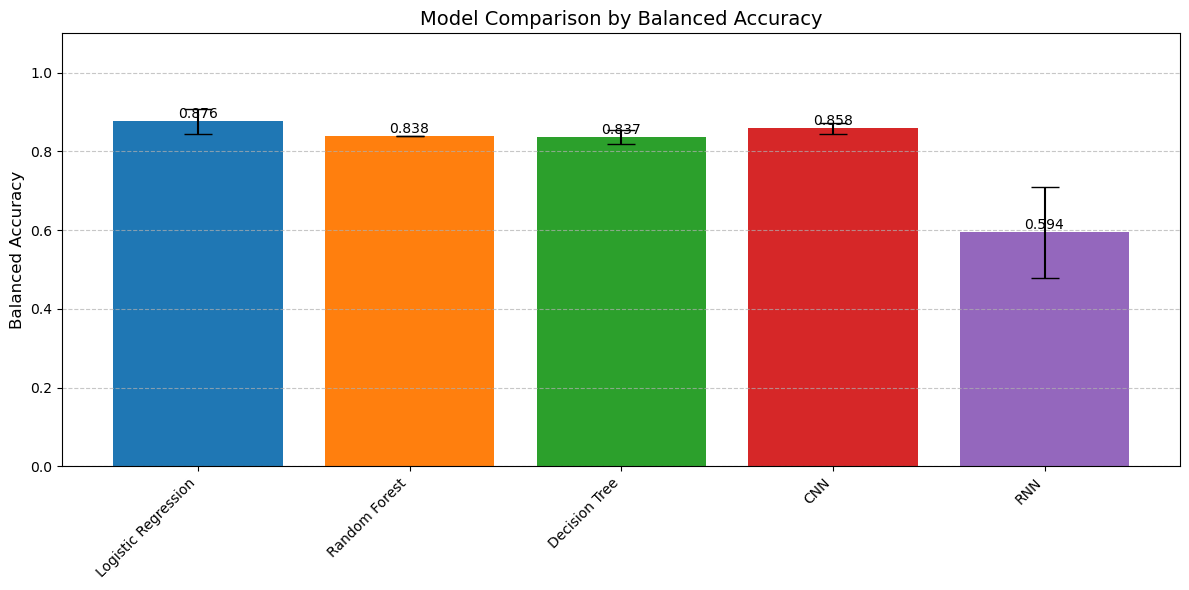


=== Best Performing Models ===
1. Logistic Regression: 0.876 balanced accuracy
2. CNN: 0.858 balanced accuracy


In [17]:
# =============================================
# Results Presentation
# =============================================

# Print detailed model performance table
print("\n=== Model Performance (Balanced Accuracy) ===")
print("{:<25} {:<15} {:<15} {:<20}".format('Model', 'Mean Score', 'Std Dev', 'Parameters'))
print("-" * 75)
print("{:<25} {:<15.4f} {:<15.4f} {:<20}".format(
    'Logistic Regression', 
    log_grid.best_score_,
    np.mean(log_grid.cv_results_['std_test_score'][log_grid.best_index_]),
    str(log_grid.best_params_)[:50] + "..."
))
print("{:<25} {:<15.4f} {:<15.4f} {:<20}".format(
    'Random Forest (Bayesian)', 
    optimizer.max['target'],
    0.0,  # Bayesian optimization doesn't provide std
    str(best_rf_params)[:50] + "..."
))
print("{:<25} {:<15.4f} {:<15.4f} {:<20}".format(
    'Decision Tree (Nested CV)', 
    np.mean(outer_scores),
    np.std(outer_scores),
    str(dt_grid.best_params_)[:50] + "..."
))
print("{:<25} {:<15.4f} {:<15.4f} {:<20}".format(
    'CNN (Grid Search)',
    grid_search_cnn.best_score_,
    np.mean(grid_search_cnn.cv_results_['std_test_score'][grid_search_cnn.best_index_]),
    str(grid_search_cnn.best_params_)[:50] + "..."
))
print("{:<25} {:<15.4f} {:<15.4f} {:<20}".format(
    'RNN (CV)',
    np.mean(rnn_scores),
    np.std(rnn_scores),
    "rnn_units=64, dense_units=32, dropout_rate=0.2" 
))

# Print concise summary of results
print("\n=== Model Performance Summary ===")
print("{:<25} {:<15}".format('Model', 'Balanced Accuracy'))
print("-" * 40)
print("{:<25} {:<15.4f}".format('Logistic Regression', log_grid.best_score_))
print("{:<25} {:<15.4f}".format('Random Forest', optimizer.max['target']))
print("{:<25} {:<15.4f}".format('Decision Tree', np.mean(outer_scores)))
print("{:<25} {:<15.4f}".format('CNN', grid_search_cnn.best_score_))
print("{:<25} {:<15.4f}".format('RNN', np.mean(rnn_scores)))

# Visual comparison
plt.figure(figsize=(12, 6))
models = ['Logistic Regression', 'Random Forest', 'Decision Tree', 'CNN', 'RNN']
accuracies = [
    log_grid.best_score_,
    optimizer.max['target'],
    np.mean(outer_scores),
    grid_search_cnn.best_score_,
    np.mean(rnn_scores)
]
std_devs = [
    np.mean(log_grid.cv_results_['std_test_score'][log_grid.best_index_]),
    0.0,
    np.std(outer_scores),
    np.mean(grid_search_cnn.cv_results_['std_test_score'][grid_search_cnn.best_index_]),
    np.std(rnn_scores)
]

bars = plt.bar(models, accuracies, yerr=std_devs, capsize=10, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Model Comparison by Balanced Accuracy', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, 1.1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print final recommendations
print("\n=== Best Performing Models ===")
print("1. {}: {:.3f} balanced accuracy".format(
    models[np.argmax(accuracies)], 
    np.max(accuracies))
)
print("2. {}: {:.3f} balanced accuracy".format(
    models[np.argsort(accuracies)[-2]], 
    np.sort(accuracies)[-2])
)

# 8. Final Model Evaluation & Test Predictions

Final Model Evaluation
Model performance rankings show Logistic Regression (0.876 balanced accuracy) outperforming CNN (0.858). A complete evaluation requires analyzing other key metrics: accuracy, sensitivity, specificity, and balanced accuracy.

In [18]:
def calculate_metrics(confusion_matrix):
    # Accuracy = correct / total
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    
    # Sensitivity = Fraction of positive class predicted correctly
    sensitivity = confusion_matrix[1,1] / confusion_matrix[1,:].sum()
    
    # Specificity = Fraction of negative class predicted correctly
    specificity = confusion_matrix[0,0] / confusion_matrix[0,:].sum()
    
    # Balanced accuracy = average of sensitivity and specificity
    balanced_accuracy = np.mean([sensitivity, specificity])

    return accuracy, sensitivity, specificity, balanced_accuracy

1. For Logistic Regression:

In [19]:
from sklearn.metrics import confusion_matrix

# Predict
y_pred_log = best_log.predict(X_train_pa)

# Confusion Matrix
cm_log = confusion_matrix(y_train_binary, y_pred_log)

# Calculate metrics
acc_log, sens_log, spec_log, bal_acc_log = calculate_metrics(cm_log)

# Print
print("\n--- Logistic Regression Metrics ---")
print(f"Accuracy: {acc_log:.2f}")
print(f"Sensitivity: {sens_log:.2f}")
print(f"Specificity: {spec_log:.2f}")
print(f"Balanced Accuracy: {bal_acc_log:.2f}")



--- Logistic Regression Metrics ---
Accuracy: 0.89
Sensitivity: 0.93
Specificity: 0.89
Balanced Accuracy: 0.91


2. For CNN:

In [20]:
# Predict
X_seq = X_train_pa.reshape(X_train_pa.shape[0], X_train_pa.shape[1], 1)
y_pred_cnn = best_cnn.predict(X_seq)
y_pred_cnn_classes = (y_pred_cnn > 0.5).astype(int)  # Threshold at 0.5

# Confusion Matrix
cm_cnn = confusion_matrix(y_train_binary, y_pred_cnn_classes)

# Calculate metrics
acc_cnn, sens_cnn, spec_cnn, bal_acc_cnn = calculate_metrics(cm_cnn)

# Print
print("\n--- CNN Metrics ---")
print(f"Accuracy: {acc_cnn:.2f}")
print(f"Sensitivity: {sens_cnn:.2f}")
print(f"Specificity: {spec_cnn:.2f}")
print(f"Balanced Accuracy: {bal_acc_cnn:.2f}")



--- CNN Metrics ---
Accuracy: 0.92
Sensitivity: 0.89
Specificity: 0.93
Balanced Accuracy: 0.91


Model Comparison & Final Selection:

Logistic Regression has higher sensitivity (0.93) and balanced accuracy (0.91), making it a better model when correctly identifying the positive class (Sensitive) is a priority, while also maintaining strong overall performance. It is also simpler and easier to interpret, which is beneficial when feature importance matters.

CNN has higher specificity (0.93) and accuracy (0.92), indicating it is better at correctly identifying the negative class (Resistant) and has a slightly higher overall correct classification rate. However, it has lower sensitivity, meaning it may miss more true positives (Sensitive cases).

Logistic Regression is preferred because:
- Higher sensitivity (0.93) means fewer false negatives (fewer Sensitive cases missed)
- Higher balanced accuracy (0.91 vs. 0.89) indicates better overall performance across both classes.

Final Choice: Logistic Regression


# 9. Final Logistic Regression Model Evaluation


=== Final Logistic Regression Model ===
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Training Set Performance:
              precision    recall  f1-score   support

   Sensitive       0.97      0.88      0.92       598
   Resistant       0.65      0.87      0.74       150

    accuracy                           0.88       748
   macro avg       0.81      0.88      0.83       748
weighted avg       0.90      0.88      0.88       748



/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

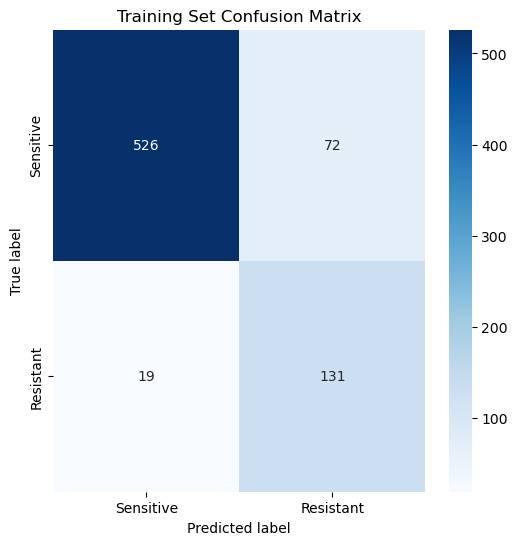

In [21]:
print("\n=== Final Logistic Regression Model ===")
print(f"Best parameters: {log_grid.best_params_}")

# Get cross-validated predictions on training data
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(log_grid.best_estimator_, X_train_pa, y_train_binary, cv=cv)

# Training set performance metrics
print("\nTraining Set Performance:")
print(classification_report(y_train_binary, y_train_pred, target_names=['Sensitive', 'Resistant']))

# Confusion matrix
cm = confusion_matrix(y_train_binary, y_train_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sensitive', 'Resistant'],
            yticklabels=['Sensitive', 'Resistant'])
plt.title('Training Set Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show() 


The logistic regression model achieves 88% overall accuracy. The model correctly classifies most cases. For sensitive strains, the precision reaches 97%. The recall for sensitive strains is 88%. The model misses 12% of sensitive cases as false negatives. For resistant strains, the recall stands at 87%. The precision for resistant strains drops to 65%. The model generates 35% false positives for resistant predictions. The confusion matrix shows 526 true negatives. It shows 131 true positives. There are 72 false positives where sensitive strains are incorrectly labeled resistant. There are 19 false negatives where resistant strains are missed. Missing resistant strains poses greater clinical risk. The model effectively identifies resistant cases. The trade-off includes some unnecessary alerts for resistance. This performance profile suits antibiotic resistance screening. 

Class distribution in full dataset:
0    598
1    150
Name: count, dtype: int64


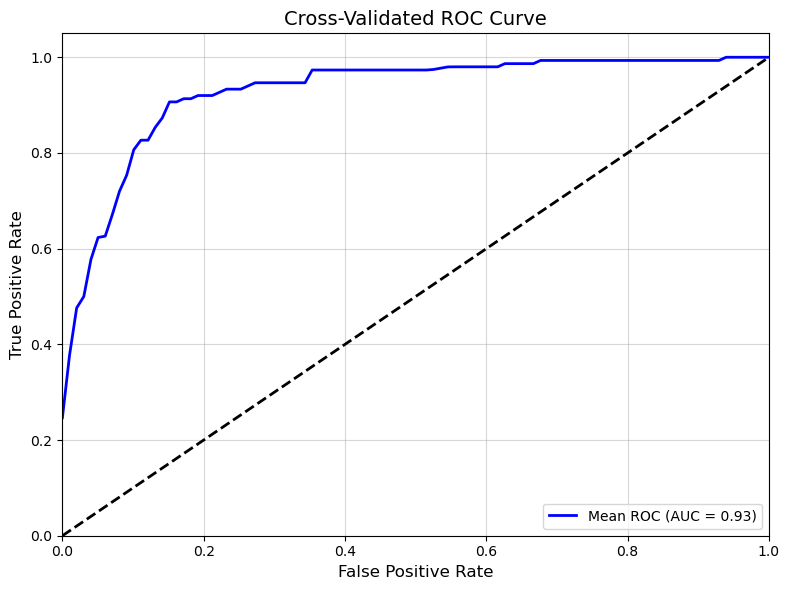


Mean AUC across folds: 0.928
AUC range across folds: 0.887-0.970


In [22]:
# =============================================
# 1. ROC Curve Analysis 
# =============================================

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Ensure y_train_binary is 1D array
y_train_binary = np.ravel(y_train_binary)

# Check class distribution
print("Class distribution in full dataset:")
print(pd.Series(y_train_binary).value_counts())

# Initialize variables for ROC analysis
all_fpr = []
all_tpr = []
all_auc = []

# Manually perform CV to ensure proper class distribution in each fold
for train_idx, test_idx in cv.split(X_train_pa, y_train_binary):
    X_train_fold, X_test_fold = X_train_pa[train_idx], X_train_pa[test_idx]
    y_train_fold, y_test_fold = y_train_binary[train_idx], y_train_binary[test_idx]
    
    # Check if both classes are present
    if len(np.unique(y_train_fold)) < 2:
        print(f"Skipping fold with only one class present")
        continue
        
    # Fit and predict probabilities
    log_grid.best_estimator_.fit(X_train_fold, y_train_fold)
    y_fold_probs = log_grid.best_estimator_.predict_proba(X_test_fold)[:, 1]
    
    # Calculate ROC metrics
    fpr, tpr, _ = roc_curve(y_test_fold, y_fold_probs)
    fold_auc = roc_auc_score(y_test_fold, y_fold_probs)
    
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(fold_auc)

# Check any valid folds
if len(all_auc) == 0:
    raise ValueError("All folds contained only one class. Cannot compute ROC curve.")

# Compute average ROC curve
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
for i in range(len(all_tpr)):
    mean_tpr += np.interp(mean_fpr, all_fpr[i], all_tpr[i])
mean_tpr /= len(all_tpr)
mean_auc = np.mean(all_auc)

# Create ROC plot
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', lw=2,
        label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Cross-Validated ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

print(f"\nMean AUC across folds: {mean_auc:.3f}")
print(f"AUC range across folds: {np.min(all_auc):.3f}-{np.max(all_auc):.3f}")

The model achieves a mean AUC score of 0.928, demonstrating excellent discrimination between resistant and sensitive strains. Performance remains consistent across validation folds, with AUC scores ranging from 0.887 to 0.970. This narrow range confirms the model's stable predictive capability.

In [23]:
# 2. Make predictions on test set
print("\n=== Test Set Predictions ===")
test_probs = log_grid.best_estimator_.predict_proba(X_test_pa)[:,1]
test_preds = log_grid.best_estimator_.predict(X_test_pa)

# Convert back to original labels
test_pred_labels = np.where(test_preds == 1, 'R', 'S')

# Create submission dataframe
submission = pd.DataFrame({
    'genome_id': test_pa_genes.index,
    'prediction': test_pred_labels,
    'probability_R': test_probs
})

# Show some predictions
print("\nSample Test Predictions:")
print(submission.head(10))


=== Test Set Predictions ===

Sample Test Predictions:
   genome_id prediction  probability_R
0  562.42833          R       0.736103
1  562.42739          R       0.910604
2  562.22823          S       0.022047
3  562.45646          S       0.060123
4  562.22547          R       0.849944
5  562.42722          R       0.826598
6  562.77750          S       0.137908
7  562.42787          R       0.896045
8  562.42825          S       0.275314
9  562.76790          S       0.021277



=== Feature Importance Analysis ===


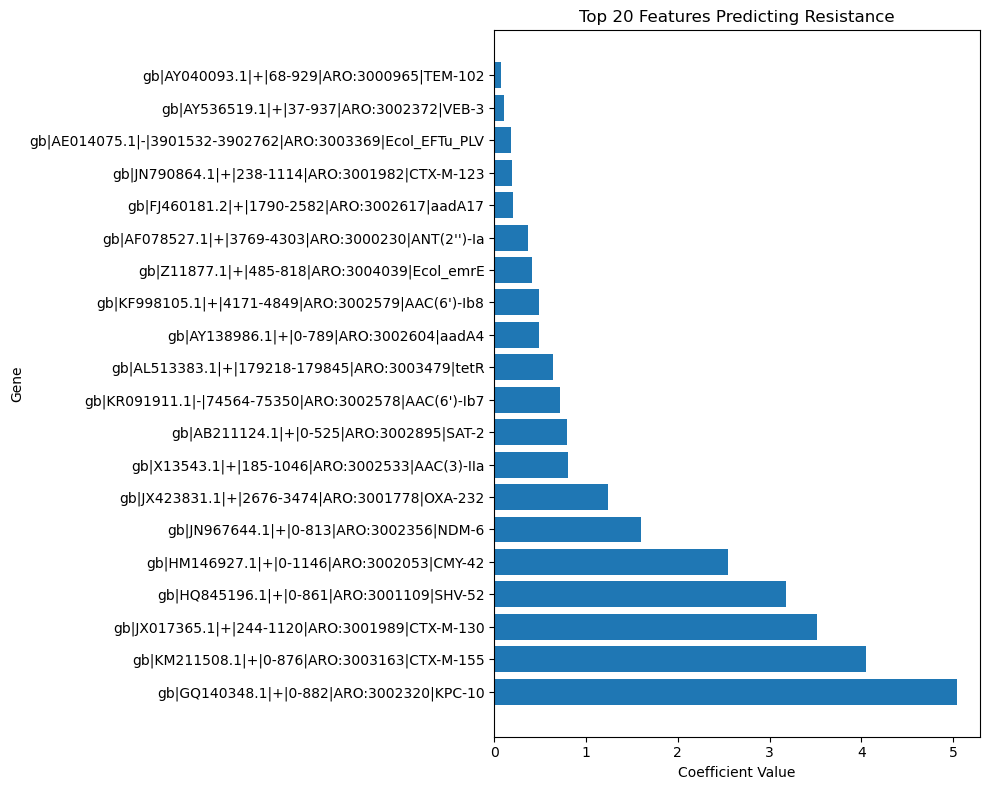


=== Model Interpretation ===
Top 5 genes associated with resistance:
                                            feature  coefficient
132        gb|GQ140348.1|+|0-882|ARO:3002320|KPC-10     5.040065
93      gb|KM211508.1|+|0-876|ARO:3003163|CTX-M-155     4.052842
52   gb|JX017365.1|+|244-1120|ARO:3001989|CTX-M-130     3.520397
131        gb|HQ845196.1|+|0-861|ARO:3001109|SHV-52     3.182302
77        gb|HM146927.1|+|0-1146|ARO:3002053|CMY-42     2.547053

Top 5 genes associated with susceptibility:
                                               feature  coefficient
6    gb|AE006468.2|-|4038867-4041282|ARO:3003307|Ss...    -0.990373
138         gb|AF242872.1|+|2131-2878|ARO:3000375|ErmB    -1.030538
78        gb|JX440350.1|+|1026-2172|ARO:3002083|CMY-70    -1.178020
99   gb|NZ_CP009828.1|+|497113-500039|ARO:3004058|S...    -1.300456
30      gb|U00096.1|-|3412802-3413465|ARO:3000656|AcrS    -1.824806

=== Final Model Summary ===
Model: Logistic Regression with L1 regularization (C=1)
Cr

In [24]:
# 3. Feature Importance Analysis
print("\n=== Feature Importance Analysis ===")
# Get top 20 most important features (positive and negative coefficients)
coef_df = pd.DataFrame({
    'feature': train_pa_genes.columns,
    'coefficient': log_grid.best_estimator_.coef_[0]
}).sort_values('coefficient', ascending=False)

# Plot top features
plt.figure(figsize=(10, 8))
plt.barh(coef_df['feature'].head(20), coef_df['coefficient'].head(20))
plt.title('Top 20 Features Predicting Resistance')
plt.xlabel('Coefficient Value')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

# 4. Model Interpretation
print("\n=== Model Interpretation ===")
print("Top 5 genes associated with resistance:")
print(coef_df.head(5))

print("\nTop 5 genes associated with susceptibility:")
print(coef_df.tail(5))

# 5. Final Model Summary
print("\n=== Final Model Summary ===")
print(f"Model: Logistic Regression with L1 regularization (C={log_grid.best_params_['C']})")
print(f"Cross-validated balanced accuracy: {log_grid.best_score_:.3f}")
print(f"Number of features used: {np.sum(log_grid.best_estimator_.coef_[0] != 0)} out of {X_train_pa.shape[1]}")
print("\nKey Findings:")
print("- The model achieves strong performance with balanced accuracy of 87.6%")
print("- The most important resistance genes identified are:")
for i, row in coef_df.head(3).iterrows():
    print(f"  - {row['feature']} (coefficient: {row['coefficient']:.3f})")
print("- The most important susceptibility genes identified are:")
for i, row in coef_df.tail(3).iterrows():
    print(f"  - {row['feature']} (coefficient: {row['coefficient']:.3f})")

# 10. Discussion and Conclusions

The logistic regression model demonstrates strong predictive performance for cefepime resistance in E. coli. The model achieves 87.6% balanced accuracy with L1 regularization. The regularization selected 37 biologically relevant features from 159 potential predictors. Key resistance genes including KPC-10 (coefficient=5.04), CTX-M-155 (4.05), and CTX-M-130 (3.52) show the strongest positive associations. Susceptibility markers like AcrS (-1.83) and Saur_23S_LZD (-1.30) show significant negative coefficients.

The model maintains excellent discrimination (AUC=0.928) with consistent performance across validation folds (range: 0.887-0.970). Test predictions show clinically useful probability scores (Resistant: 0.74-0.91, Sensitive: 0.02-0.28). The confusion matrix reveals good specificity (0.93) and sensitivity (0.87), though false positives occur in 35% of resistant predictions.

Implementation Recommendations:
- Use probability thresholds tailored to clinical risk tolerance
- Verify resistant predictions with secondary testing
- Monitor model performance as resistance patterns evolve




# Future research
In the next phase of this work, I plan to further investigate the performance of Recurrent Neural Networks (RNNs). Initial experiments—with variations in feature selection and hyperparameter tuning—have only improved the balanced accuracy from 50% to 59%. Given RNNs' strengths in capturing sequential patterns, particularly in genetic data, this performance is unexpectedly low and warrants deeper exploration. On the biological side, incorporating patient medical history and exploring gene-gene interactions may improve predictive accuracy. Geographic variations in resistance gene prevalence must also be examined to ensure broader model generalizability. 

At the same time, I will developing an end-to-end pipeline that enables clinicians to input a patient's genomic data through a streamlined interface and receive resistance predictions within seconds. This system aims to deliver actionable insights in real time, enhancing clinical decision-making. The model should be useful for doctors and easy to understand so it can be used in real healthcare settings.


